## Advanced Lane Line Detection
Zikri Bayraktar, Ph.D.

I utilized some code from the lectures to complete the project

In [1]:
# Import needed libraries first:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

##### Define some  functions

In [2]:
# Select the Yellow color on the image
# Recommeded in my first submission review:
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

In [3]:
# Select the White color on the image
# Recommeded in my first submission review:
def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

In [4]:
def threshold_gradient_and_color(undistortimg, thresh_min, thresh_max, s_thresh_min, s_thresh_max, l_thresh_min, l_thresh_max):
    
    #RGB color channels to get Yellow and White lines:
    yellow = select_yellow(undistortimg)
    white = select_white(undistortimg)
    combined_color = np.zeros_like(yellow)
    combined_color[(yellow >= 1) | (white >= 1)] = 1
    
    #H-L-S channels
    hls = cv2.cvtColor(undistortimg, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # grayscale of the image:
    gray = cv2.cvtColor(undistortimg, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold s-channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Threshold l-channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1    
    combined_binary[((s_binary == 1) & (l_binary ==1)) | (sxbinary == 1)] = 1    
    
    # Combine color as well as other thresholdings:
    combined_return = np.zeros_like(sxbinary)
    combined_return[(combined_color >= 1) | (combined_binary >= 1)] =1
    
    return combined_return

In [5]:
# Function to mask the Region of Interest (lane lines) in the image to ignore background:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    imDim = img.shape  # dimensions of the image
    xsc = imDim[1]/960  #xscale factor for different size images
    ysc = imDim[0]/540  #yscale factor for different size images

    Xoffst = 40 * xsc
    Yoffst = 40 * ysc
    
    vertices = np.array([[(Xoffst, imDim[0]-Yoffst), (int(xsc*450),int(ysc*320)), (int(xsc*520),int(ysc*320)), (imDim[1]-Xoffst,imDim[0]-Yoffst)]], dtype=np.int32)

    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
# Perspective transform function on a given image:
def warp(img):
    # define calibration box in source and destination coordinates
    img_size = (img.shape[1], img.shape[0])
   
    # I utilized the recommended coordinates in the writeup, and tuned a little to make it work.
    # source points
    src = np.float32(   [[(img_size[0] / 2) - 61, img_size[1] / 2 + 100],
                        [((img_size[0] / 6) - 10), img_size[1]],
                        [(img_size[0] * 5 / 6) + 60, img_size[1]],
                        [(img_size[0] / 2 + 61), img_size[1] / 2 + 100]])
    
    # destionation points
    dst = np.float32(   [[(img_size[0] / 4), 0],
                        [(img_size[0] / 4), img_size[1]],
                        [(img_size[0] * 3 / 4), img_size[1]],
                        [(img_size[0] * 3 / 4), 0]])
    
    # Compute the perspective trasform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

In [16]:
# Function for sliding window and computing the polynomials and car center offset:

def sliding_window(binary_warped, nwindows=9, margin=100, minpix=50):
    
    ym_per_pix = 30.0/binary_warped.shape[0]  # meters per pixel in y dimension
    xm_per_pix = 3.7/binary_warped.shape[1]   # meters per pixel in x dimension
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    car_center = (leftx_base+rightx_base)*xm_per_pix/2.0
    lane_center = binary_warped.shape[1]*xm_per_pix/2.0
    car_offset =  car_center - lane_center   #this is the car offset from the center of the lane.
    

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each in the pixel world
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in real world space (meters)
    left_fitm = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fitm = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    return left_fit, right_fit, left_fitm, right_fitm, left_lane_inds, right_lane_inds, car_offset, ym_per_pix, xm_per_pix 

### Section 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [8]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space.
imgpoints = [] # 2d points in image plane.

# Note that the internal corners of the calibration chessboard is 9x6
nx=9
ny=6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

In [9]:
# Make a list of calibration images provided by Udacity:
images = glob.glob('camera_cal/calibration*.jpg')

In [10]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

cv2.destroyAllWindows()

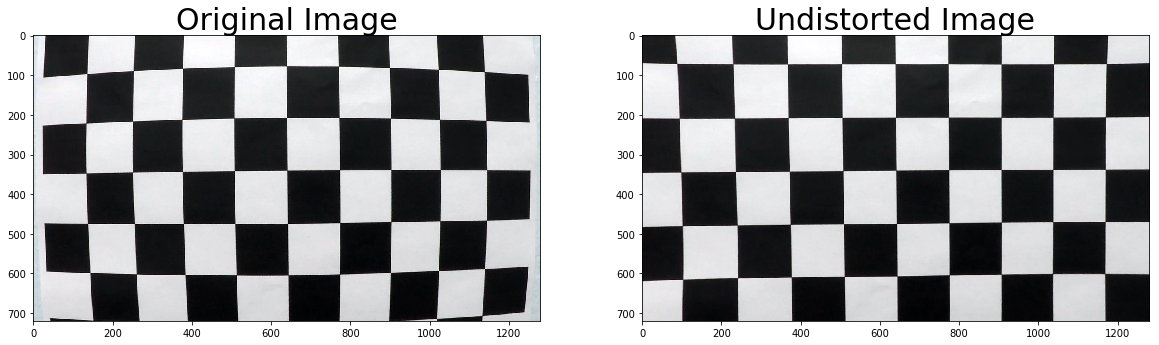

In [11]:
# Test undistortion on an image
img = cv2.imread('test_calibration.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Section 2. Pipeline (per image)

In [12]:
def pipeline(imgIN, thresh_min=40, thresh_max=100, s_thresh_min=150, s_thresh_max=255, l_thresh_min=30, l_thresh_max=255):
    
    # STEP 1: Undistory the image first using the calibration matrix:
    #shape of the image:
    img_size = (imgIN.shape[1], imgIN.shape[0])
    #undistort the image per the initial calibration
    undistortimg = cv2.undistort(imgIN, mtx, dist, None, mtx)
    
    
    # STEP 2: Color and gradient thresholding of the image:
    combined_binary = threshold_gradient_and_color(undistortimg, thresh_min, thresh_max, s_thresh_min, s_thresh_max, l_thresh_min, l_thresh_max)

    
    # STEP 3: Mask the region of interest to eliminate the background:
    # Select the region of interest:
    masked_image = region_of_interest(combined_binary)
    
    
    # STEP 4: Perspective Transform the masked image
    warped_image, M, Minv = warp(masked_image)
    
    
    # STEP 5: Use sliding window approach to compute the curvature, also compute if car centered in lan
    # note that while left_fit is in pixel units and left_fitm is in meter units
    left_fit, right_fit, left_fitm, right_fitm, left_lane_inds, right_lane_inds, car_offset, ym_per_pix, xm_per_pix = sliding_window(warped_image)

    
    # STEP 6: Draw the regions on the image and recast onto original:
    # Create an image to draw the lines on (this is in pixel-units)
    ploty = np.linspace(0,  warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    # Draw the lane lines onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp,np.int_([pts]), True, (255,0,0), thickness=5)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 
    # Combine the result with the camera calibrated image
    result = cv2.addWeighted(undistortimg, 1, newwarp, 0.3, 0)
    
    
    # Compute the curvature in meters to display on image:
    y_eval = np.max(ploty) * ym_per_pix  #convert to meters
    left_curverad = ((1 + (2*left_fitm[0]*y_eval + left_fitm[1])**2)**1.5) / np.absolute(2*left_fitm[0])
    right_curverad = ((1 + (2*right_fitm[0]*y_eval + right_fitm[1])**2)**1.5) / np.absolute(2*right_fitm[0])
    ave_rad_curv = (left_curverad+right_curverad)/2
    text_line1 = 'Radius of curvature (m): ' +str(int(ave_rad_curv))
    
    #print(car_offset)
    if car_offset > 0:
        text_line2 = 'Car is ' + "{:.3f}".format(np.abs(car_offset)) + ' m left of center'
    if car_offset <= 0:
        text_line2 = 'Car is ' + "{:.3f}".format(np.abs(car_offset)) + ' m right of center'
    
    cv2.putText(result, text_line1, (5, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2,cv2.LINE_AA)
    cv2.putText(result, text_line2, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2,cv2.LINE_AA)
        
    return result

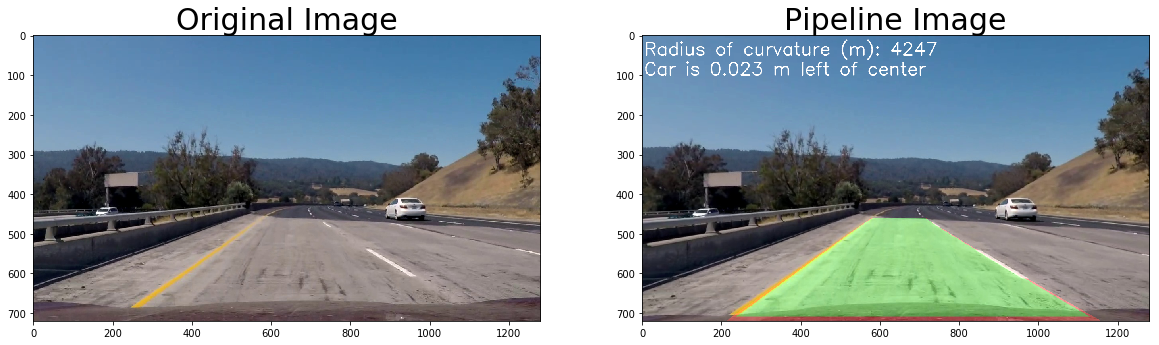

In [19]:
# Test on some images:

#image = mpimg.imread('test_concrete_05.jpg')
#image = mpimg.imread('frame767.jpg')
image = mpimg.imread('frame593.jpg')
return_image= pipeline(image)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(return_image, cmap='gray')
ax2.set_title('Pipeline Image', fontsize=30)

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
white_output = 'test_videos_output/project_video_run7.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(37,39)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_run7.mp4
[MoviePy] Writing video test_videos_output/project_video_run7.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:19<00:00,  4.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_run7.mp4 

Wall time: 4min 21s


In [13]:
### END of file